In [39]:
import numpy as np
import matplotlib.pyplot as plt

$\textbf{1) Random data generation }$

In [40]:
#Generate the training set


N_train = 1000
sigma = 0.1



# Generate W_i's as uniform random variables on [0, 5]
W = np.random.uniform(low=0, high=5, size=N_train)

# Generate Y_i's conditionally on W_i's
Y_train = np.random.normal(loc=np.cos(W), scale=sigma, size=N_train)


W1 = np.array([W]).T
Y_train1 = np.array([Y_train]).T

In [41]:
#Generate the target set (calibration + test)

N_target = 100

def f(A) : #Domain Shift
    return(0.6*A + (A**2)/25)

A = np.random.uniform(low=0, high=5, size=N_target)
X = f( A )
Y = np.random.normal(loc=np.cos(A), scale=sigma, size=N_target)

X1 = np.array([X]).T
Y1 = np.array([Y]).T


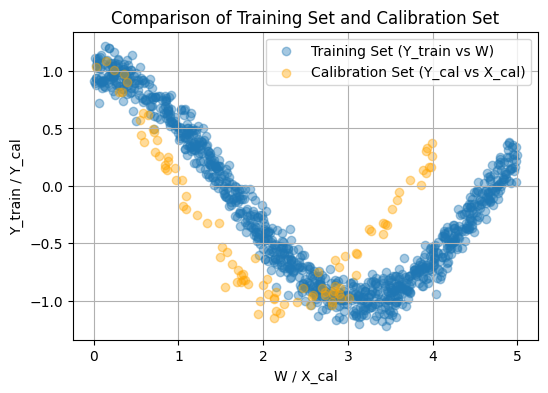

In [42]:
# Creating a combined plot to show both sets on the same graph for clearer comparison

plt.figure(figsize=(6, 4))

# Plotting Y_train vs W
plt.scatter(W, Y_train, alpha=0.4, label='Training Set (Y_train vs W)')

# Plotting Y_cal vs X_cal
plt.scatter(X, Y, alpha=0.4, color='orange', label='Calibration Set (Y_cal vs X_cal)')

plt.title('Comparison of Training Set and Calibration Set')
plt.xlabel('W / X_cal')
plt.ylabel('Y_train / Y_cal')
plt.grid(True)
plt.legend()
plt.show()

$\textbf{2) Optimal tranport and predictions}$

In [43]:
from jdot import jdot_krr
from sklearn.metrics.pairwise import rbf_kernel


g,_ = jdot_krr(W1, Y_train1, X1, gamma_g = 1, numIterBCD = 10, alpha=1,lambd=1e1,method='emd',reg=1,ktype='rbf')

In [44]:
Y_pred = g.predict(rbf_kernel(X1,X1))

Y_pred_cal = Y_pred[:50]
Y_pred_test = Y_pred[50:]

Y_cal = Y[:50]
Y_test = Y[50:]

X_cal = X[:50]
X_test = X[50:]

In [45]:
Y_cal1 = np.array([Y_cal]).T
Y_test1 = np.array([Y_test]).T

$\textbf{3) Confidence intervals and results}$

In [46]:
import seaborn as sns

colors_blindness = sns.color_palette("colorblind")
color_train = colors_blindness[1]
color_cal = colors_blindness[9]
color_test = colors_blindness[7] #(0,0,0) #colors_blindness[4]

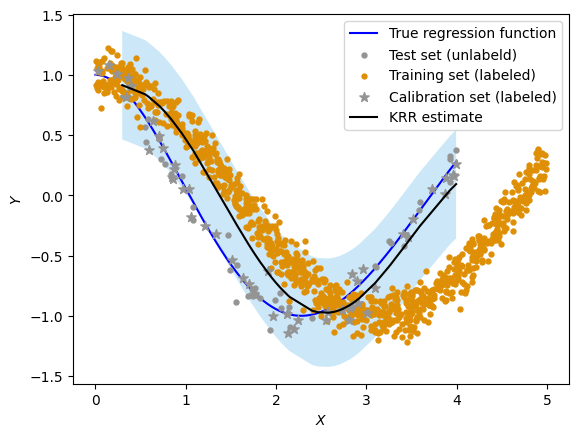

In [47]:
scores = np.abs(Y_pred_cal - Y_cal1)

#true regression function 
t_x = np.linspace(0,5,500)
t_y = np.cos((t_x))



plt.plot(f(t_x),t_y, color = 'blue', label = 'True regression function')


plt.scatter(X_test,Y_test,marker='.',color=color_test,zorder=2, s=50, label = 'Test set (unlabeld)')
plt.scatter(W,Y_train,marker='.',color=color_train,zorder=2, s=50, label = 'Training set (labeled)')
plt.scatter(X_cal,Y_cal,marker='*',color = color_test, zorder =2, s=50, label= 'Calibration set (labeled)')

beta = 0.1
n = N_target/2

quantile_scp = np.quantile(scores,np.ceil((1-beta)*(n+1))/n)# TODO OPERAND


plt.plot(X_test[np.argsort(X_test)],Y_pred_test[np.argsort(X_test)],color='black', label = 'KRR estimate')
plt.fill_between(X_test[np.argsort(X_test)],
                 Y_pred_test[np.argsort(X_test)].flatten()+quantile_scp,
                 Y_pred_test[np.argsort(X_test)].flatten()-quantile_scp,
                 fc=color_cal,alpha=.3)



plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.legend()
plt.show()

In [48]:
# Count how many times the true label was indeed 
# in the prediction interval on the test set

prop_covered_scp = np.sum(((Y_pred_test-quantile_scp)<=Y_test1)*(Y_test1<=(Y_pred_test+quantile_scp)))/len(Y_test) #TODO OPERAND

# Print coverages
print("Theoretical coverage: ",1-beta)
print("Empirical coverage with SCP: ",prop_covered_scp) 


Theoretical coverage:  0.9
Empirical coverage with SCP:  0.9
